In [3]:
import torch

In [90]:
import pandas as pd

frames = []
for f in ['file1.txt', 'file2.txt', 'file3.txt', 'file4.txt']:
    frames.append(pd.read_csv(f, sep=',', header=None, skiprows=1))

data = pd.concat(frames)

KeyboardInterrupt: 

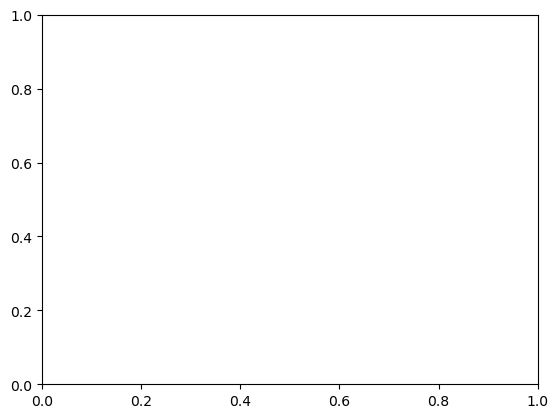

In [91]:
from matplotlib import pyplot as plt
data.plot.scatter(x=0, y=3, s=[.01] * len(data))

In [92]:
#X = torch.tensor([data[2], data[3]]).float()
data = data[data[1] != ' other']

classes = data[1].unique()
ctoi = {c: i for i, c in enumerate(classes)}
itoc = {i: c for i, c in enumerate(classes)}

X = torch.tensor(data[[2, 3]].values).float()

#Y = torch.tensor([ctoi[c] for c in data[1]]).float()
Y = torch.nn.functional.one_hot(torch.tensor([ctoi[c] for c in data[1]]), len(classes)).float()
ctoi, itoc

({' sniper': 0,
  ' scout': 1,
  ' engineer': 2,
  ' heavy': 3,
  ' pyro': 4,
  ' spy': 5,
  ' soldier': 6,
  ' medic': 7,
  ' demoman': 8},
 {0: ' sniper',
  1: ' scout',
  2: ' engineer',
  3: ' heavy',
  4: ' pyro',
  5: ' spy',
  6: ' soldier',
  7: ' medic',
  8: ' demoman'})

In [93]:
X.shape, Y.shape

(torch.Size([1485239, 2]), torch.Size([1485239, 9]))

In [94]:
# historgram of Y
Y.unique(dim=0,return_counts=True)

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([ 36663,  36681, 375190,  51266,  21307,  44628,  23479, 853244,  42781]))

In [95]:
def split_data_batches(X, Y, ratio=0.8):
    n = int(X.size(0) * ratio)
    return (X[:n, :], Y[:n, :]), (X[n:, :], Y[n:, :])

(X_train, Y_train), (X_test, Y_test) = split_data_batches(X, Y)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(torch.Size([1188191, 2]),
 torch.Size([1188191, 9]),
 torch.Size([297048, 2]),
 torch.Size([297048, 9]))

In [96]:
block_size = 66 * 10
batch_size = 256

# grab random blocks of data from the training set
def get_time_series_batches(data, labels, batch_size, window_size):
    num_samples = data.size(0)
    num_windows = num_samples - window_size + 1
    batch_indices = torch.randint(0, num_windows, (batch_size,))
    xs = []
    ys = []
    for idx in batch_indices:
        x = data[idx:idx+window_size, :]
        y = labels[idx:idx+window_size, :]

        xs.append(x)
        ys.append(y)
        

    return torch.stack(xs), torch.stack(ys)


In [106]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.fc2 = torch.nn.LSTM(block_size * 2, 50, 2, batch_first=True, bidirectional=True)
        # expects B x C x T
        self.fc1 = torch.nn.Conv1d(2, 5, 10)
        self.con2 = torch.nn.Conv1d(5, 10, 10)
        self.con3 = torch.nn.Conv1d(10, 1, 10)
        # input, hidden, layers
        self.fc2 = torch.nn.LSTM(559, 200, 4, batch_first=True, bidirectional=False)
        self.fc3 = torch.nn.Linear(200, 50)
        self.fc4 = torch.nn.Linear(50, Y.shape[1])
        #self.last = torch.nn.Softmax()

    def forward(self, x):
        x = x.view(-1, 2, block_size)
        #x = x.reshape(-1, block_size * 2)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.con2(x)
        x = torch.relu(x)
        x = self.con3(x)

        # x = torch.squeeze(x, dim=1)
        x = torch.relu(x)
        x,_ = self.fc2(x)
        x = torch.relu(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        #x = self.last(x)
        return x
    
net = Net()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [107]:
losses = []
validation_losses = []

In [125]:
optimizer.lr = 0.001
for epoch in range(1000):
    optimizer.zero_grad()
    X_batch, Y_batch = get_time_series_batches(X_train, Y_train, batch_size, block_size)
    Y_pred = net(X_batch)
    Y_batch = Y_batch[:, -1, :]
   # print(Y_batch.shape, Y_pred.shape)
    Y_pred = Y_pred.view(-1, Y.shape[1])

    
    l = loss(Y_pred, Y_batch)
    l.backward()
    optimizer.step()
    losses.append(l.item())
    if epoch % 100 == 0:
        print(f'Epoch {epoch}: {l.item()}')

    with torch.no_grad():
        X_batch, Y_batch = get_time_series_batches(X_test, Y_test, batch_size, block_size)
        Y_pred = net(X_batch)
       # print(Y_pred.shape, Y_batch.shape)
        Y_pred = Y_pred.view(-1, Y.shape[1])
        Y_batch = Y_batch[:, -1, :].squeeze(1)
        #print(Y_pred.shape, Y_batch.shape)

        #Y_batch = Y_batch[:, 0, :]
        l = loss(Y_pred, Y_batch)
        validation_losses.append(l.item())

Epoch 0: 2.2041046619415283
Epoch 100: 1.1010807752609253
Epoch 200: 1.1913522481918335
Epoch 300: 0.9841247797012329
Epoch 400: 1.037317156791687
Epoch 500: 1.1043790578842163
Epoch 600: 0.9297835230827332
Epoch 700: 1.0683326721191406
Epoch 800: 0.9884139895439148
Epoch 900: 1.1611707210540771


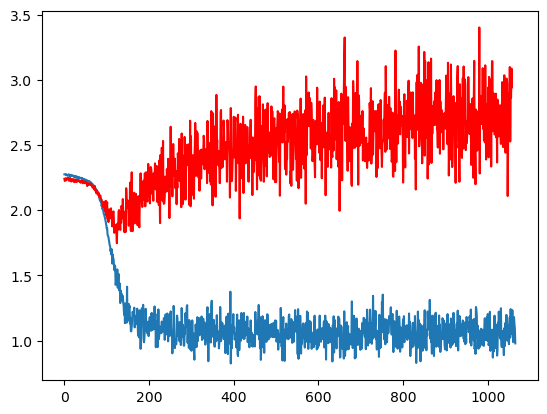

In [126]:
from matplotlib import pyplot as plt
plt.plot(torch.tensor(losses).view(-1,1).mean(dim=(1)), label='loss')
plt.plot(torch.tensor(validation_losses).view(-1,1).mean(dim=(1)), label='vloss', color='red')

In [127]:
#print(net(validation_x[1:2, :, :]), validation_y[1:2, 0, :])
print(net(validation_x[1:2, :, :]))
print(validation_y[1:2, 0, :])

tensor([[[-0.0631,  2.9097, -1.0965, -0.4032, -1.2008, -0.4645,  1.9833,
          -3.1569, -3.3683]]], grad_fn=<ViewBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1.]])


performance history
####

  * 3 linear layers: loss: jittery around 1.1. valdiation loss: jittery around 0.6. single shot failed
  * 1 linear, 1 lstm, 1 linear: loss around 1.3 validation loss: jittery around 0.7, single shot works
  * 1 conv1d, 1lstm, 1 linear: loss around 0.6, validation loss: around 0.6, single shot
  * 1 conv2d (flattened), 1lstm, 1linear, 1softmax: loss around 1.8, validation loss 1.3. 50% training success
  * 1 conv2d, 1 lstm, 1 linear, loss around 0.2, validation loss 0.2, 80% training success
  * 1 conv2d(5), 1 lstm, 1 linear, loss around 0.2, validation loss 0.2, 80% training success
  * 1 conv2d(20), 1 lstm, 1 linear, loss around 0.2, validation loss 0.2, 70% training success
  * 1 conv2d(3), 1 lstm(200, 2), 1 linear, loss around 0.2, validation loss 0.2, 70% training success

In [129]:
# validation_set percent right prediction

with torch.no_grad():
    n_samples = 10000
    validation_x, validation_y = get_time_series_batches(X_train, Y_train, n_samples, block_size)
    #validation_x, validation_y = get_time_series_batches(X_test, Y_test, n_samples, block_size)
    print(validation_x.shape, validation_y.shape)
    Y_pred = net(validation_x)
    print(Y_pred.shape)
    for conv in range(5):
        corect = 0
        for sample in range(n_samples):
            pred = Y_pred[sample][conv].argmax()
            val = validation_y[sample, conv, :].argmax()
            #print(pred, val)
            if pred == val:
                corect += 1
            #Y_true = torch.argmax(validation_y[:, :, :], dim=2)
            #print(Y_true)
        print(corect / n_samples)
    print(Y_pred.argmax(dim=1).unique())

torch.Size([10000, 660, 2]) torch.Size([10000, 660, 9])
torch.Size([10000, 1, 9])
0.6387


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [377]:
argmaxes = set()
for x in Y_train:
    argmaxes.add(x.argmax().item())
print(argmaxes)

{0, 1, 2, 3, 4, 5, 6, 7}


In [806]:
1/ (9 * 9)

0.012345679012345678